In [77]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys 

project_root = Path().cwd()
scripts_dir = project_root / "src" / "scripts"
sys.path.insert(0, str(scripts_dir))

import numpy as np 
import scipy.stats as stats
import scipy.io as sio
import os 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import process_2p as p2p
import lick_behav_analysis as behav
from scalebars import add_scalebar
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import classify_2p as c2p
from cmap import Colormap


#Recording parameters
fps = 15
framespertrial = 375 
ms_per_frame = int(1000//fps)
reward_frame = 150
cue_frame = 105
trials = 30
cmap= "coolwarm"

In [ ]:
paths = [
    '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fasted ensure/glp23_fastedensure_30min/suite2p/plane0',
    '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fasted ensure/glp6_fastedensure_30min/suite2p/plane0'
]
# START --- 1s delay --- image 10s --- start pump 

In [300]:
f, iscell, ops = p2p.load_s2p_data(paths[1])
matpath = os.path.join(paths[1], 'behaviordata.mat')
behaviordata = sio.loadmat(matpath)
filt_f = p2p.filter_cells(f, iscell)
filt_f_norm = p2p.normalize_data(filt_f, use_baseline = False, trial_by_trial = False)
licks = np.squeeze(behaviordata['licks']) / 1000 - 1
time = np.arange(0, f.shape[1] * ms_per_frame, ms_per_frame) / 1000
raw_bout_on, raw_bout_off = behav.label_meals(licks, min_pellets = 3, meal_duration = 5) # Max 5s between licks to be considered a meal, at least 5 licks
bout_on = []
bout_off = []
for i in range(len(raw_bout_on) - 1):
    if i == 0:
        bout_on.append(raw_bout_on[i])
        bout_off.append(raw_bout_off[i])
    elif raw_bout_on[i] - raw_bout_off[i-1] > 5: # If more than 5s between bouts, start a new bout
        bout_on.append(raw_bout_on[i])
        bout_off.append(raw_bout_off[i])
if bout_on[-1] - bout_on[-2] > 5: 
    bout_on.append(raw_bout_on[-1])
    bout_off.append(raw_bout_off[-1])

appending None


In [303]:
# Parameters
pre_window = 10  # seconds before bout onset
post_window = 50  # seconds after bout onset
window_length = pre_window + post_window
fps = 15  # frames per second
window_frames = int(window_length * fps)
pre_frames = int(pre_window * fps)
post_frames = int(post_window * fps)

# Initialize result
ncells, nframes = filt_f.shape
aligned_dff = []  # will be list of (ncells x window_frames) arrays

# Convert bout_on times to frame indices
bout_on_frames = np.searchsorted(time, bout_on)

for onset in bout_on_frames:
    start = onset - pre_frames
    end = onset + post_frames
    if start >= 0 and end <= nframes:
        aligned_trace = filt_f[:, start:end].copy()  # shape: ncells x window_frames
        for j in range(aligned_trace.shape[0]):
            aligned_trace[j, :] = (aligned_trace[j, :] / np.mean(aligned_trace[j, 0:pre_frames])) 
        aligned_dff.append(aligned_trace)

# Stack and average
aligned_dff = np.stack(aligned_dff, axis=0)  # shape: nbouts x ncells x window_frames
avg_dff = np.mean(aligned_dff, axis=0)       # shape: ncells x window_frames

# Create a time vector relative to bout onset
aligned_time = np.linspace(-pre_window, post_window, window_frames)



/var/folders/0b/00sxp7js3s12st9d5np366540000gn/T/ipykernel_99208/2521873909.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


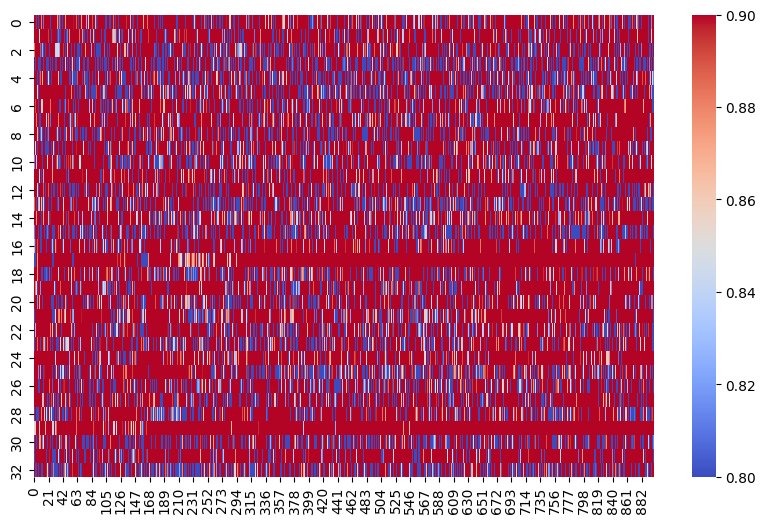

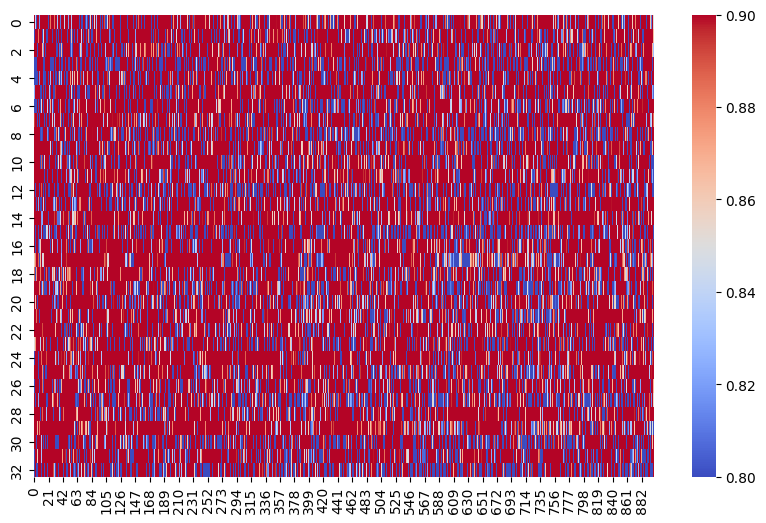

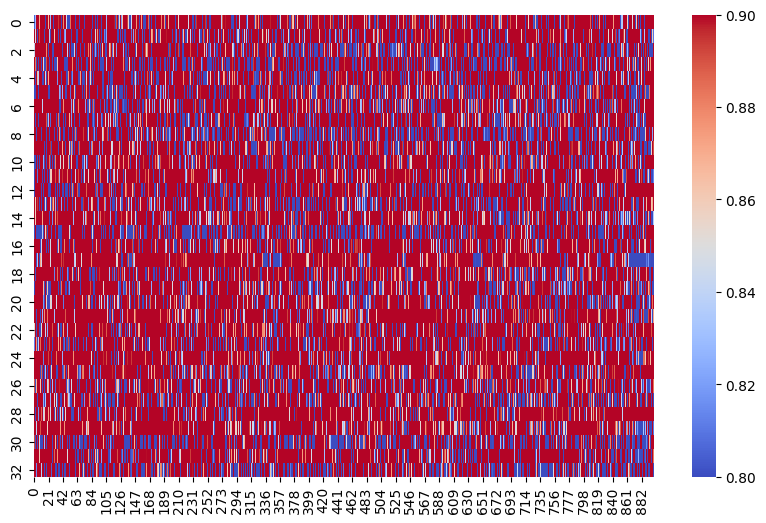

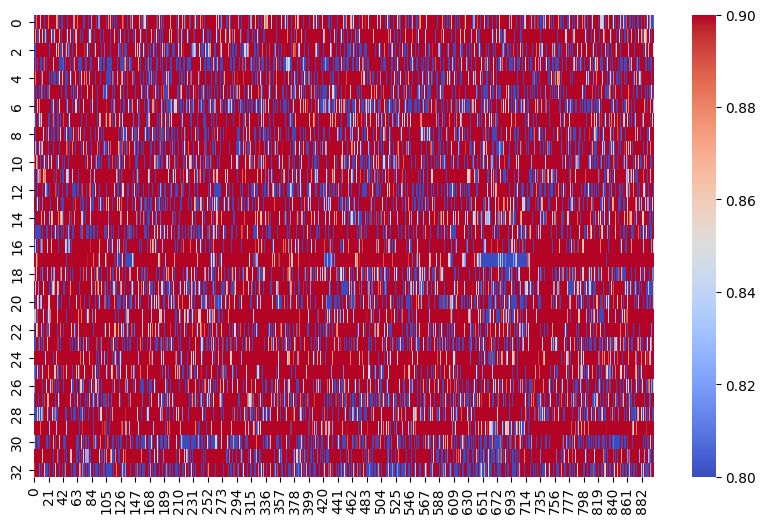

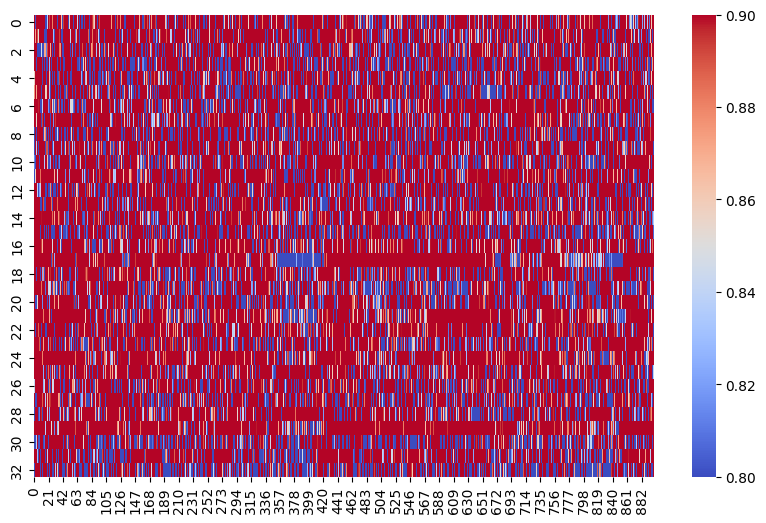

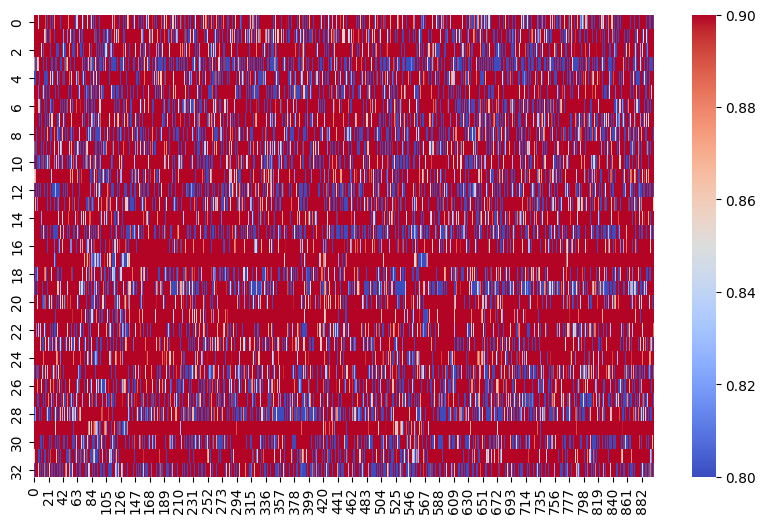

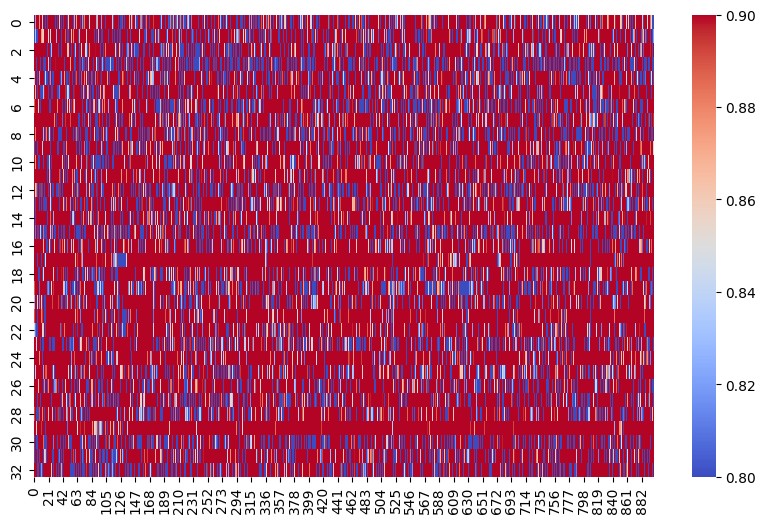

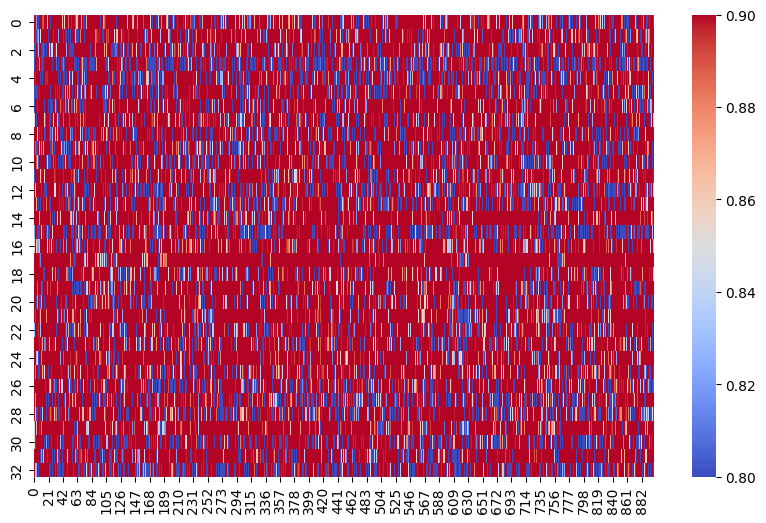

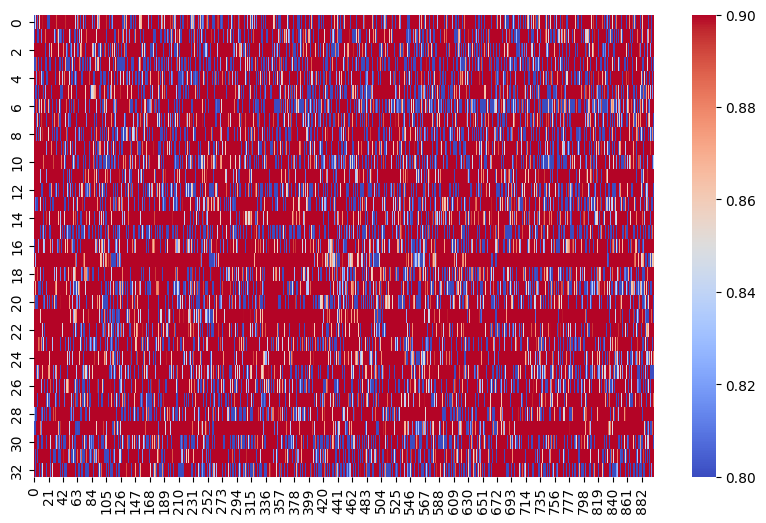

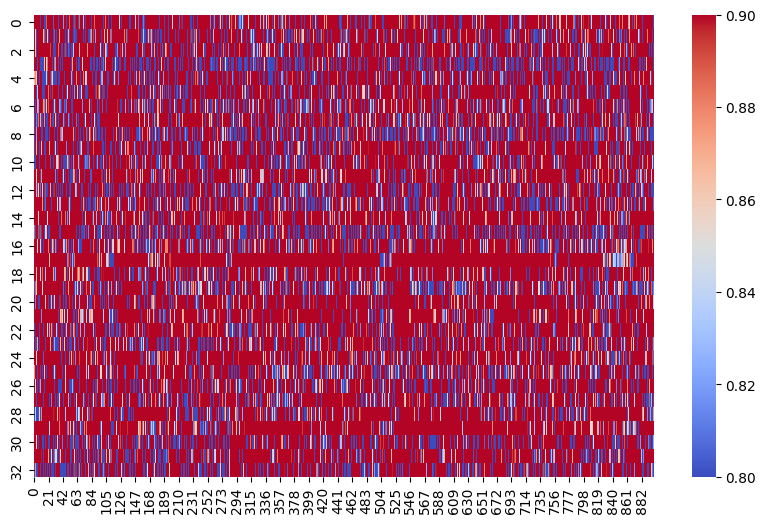

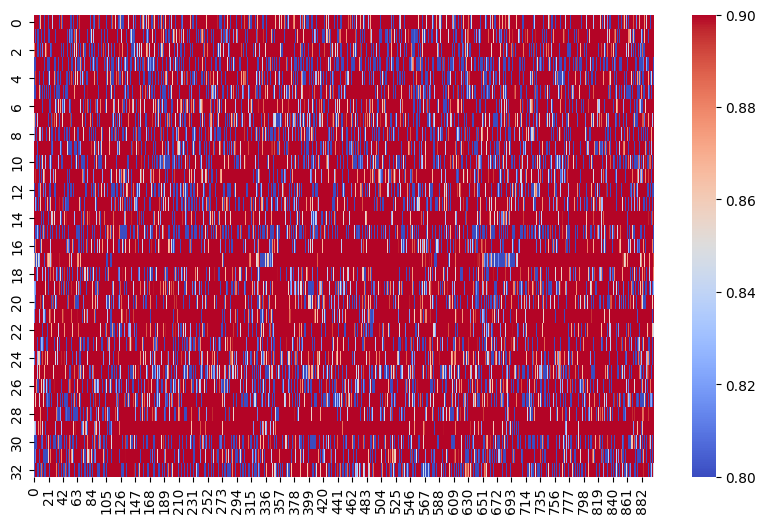

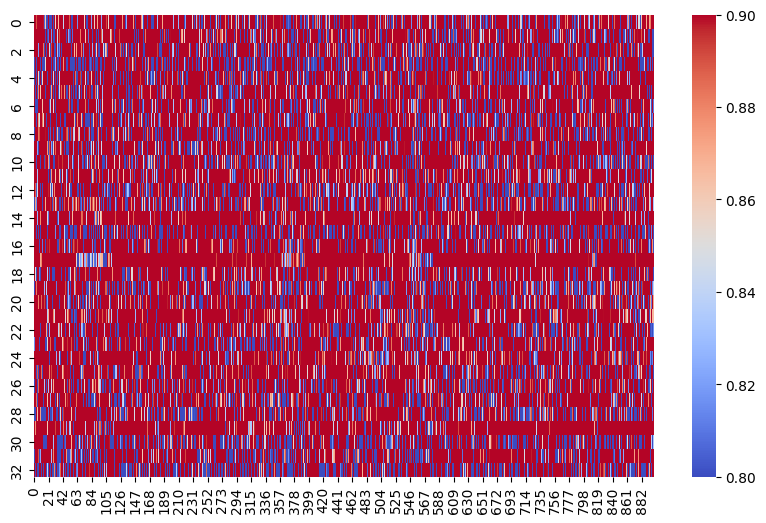

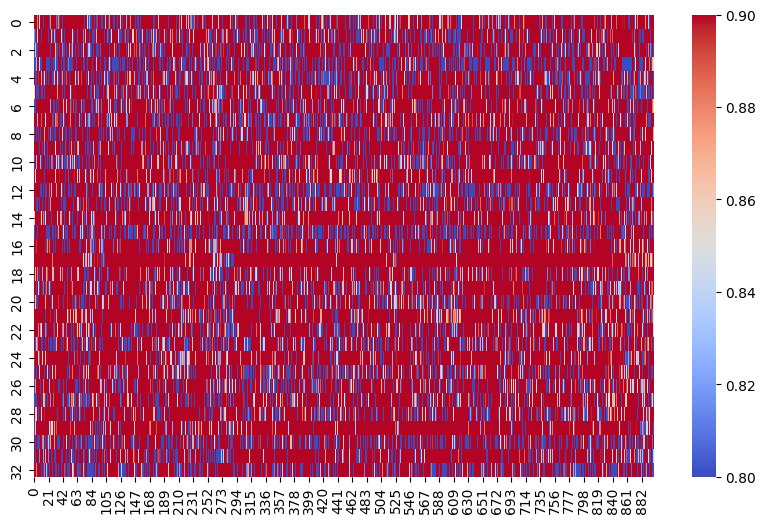

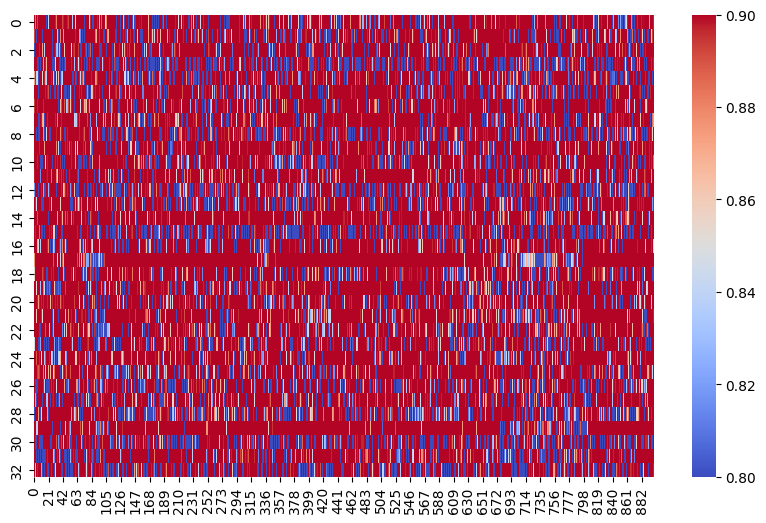

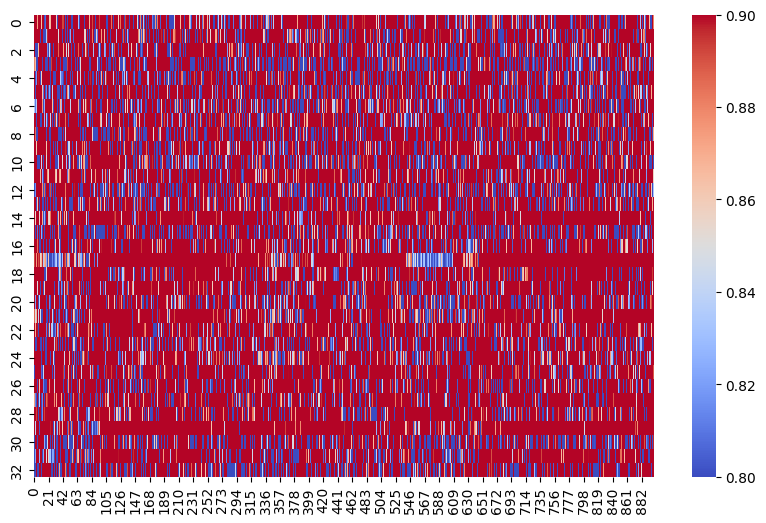

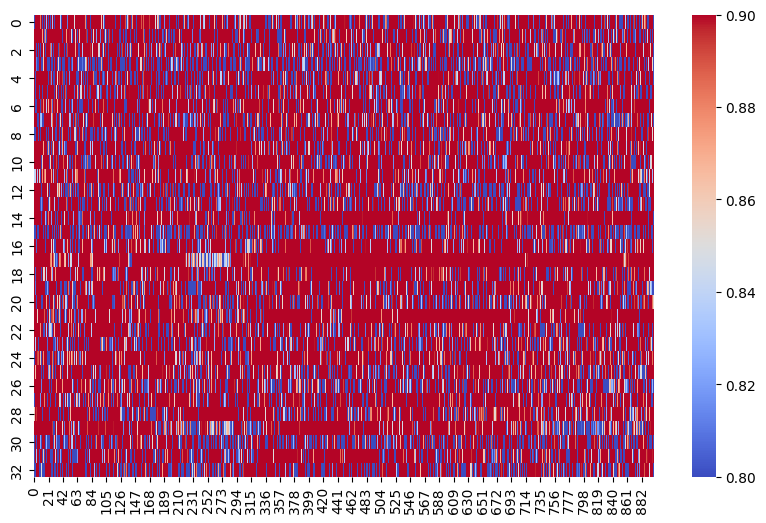

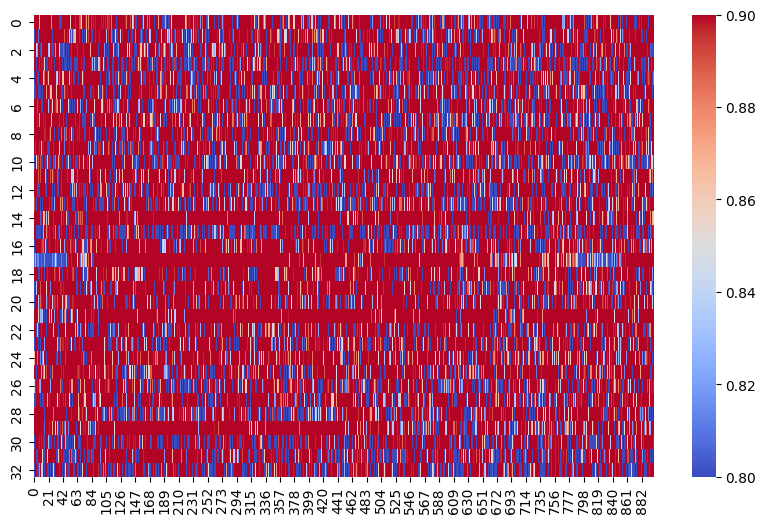

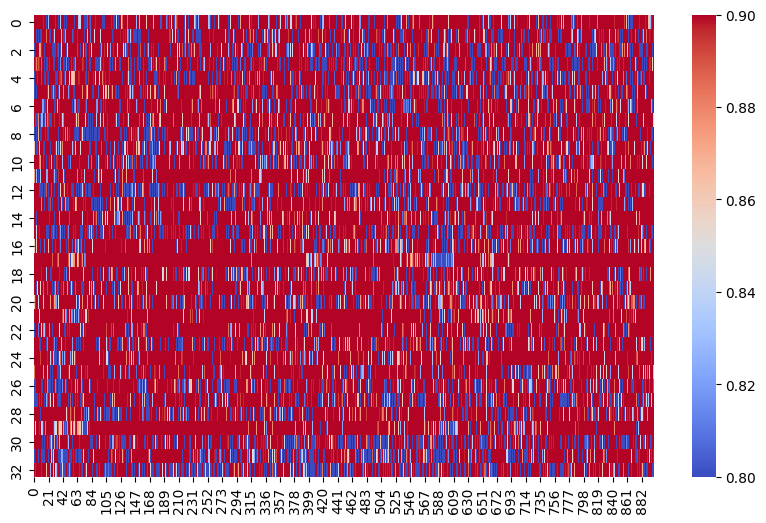

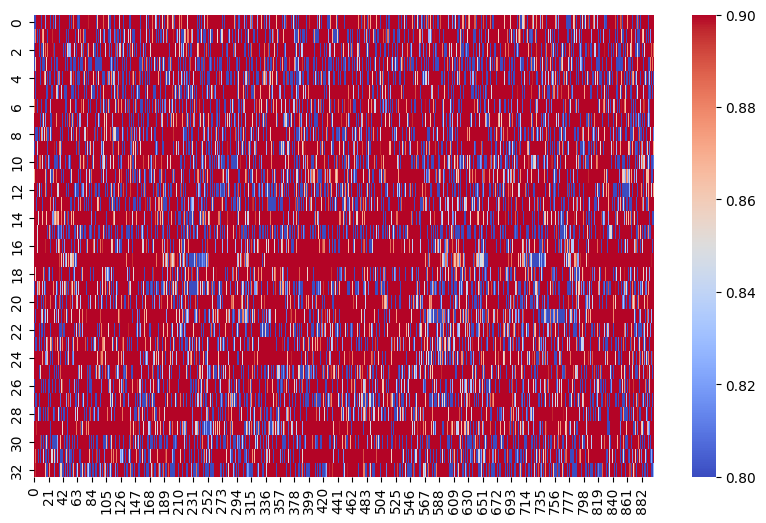

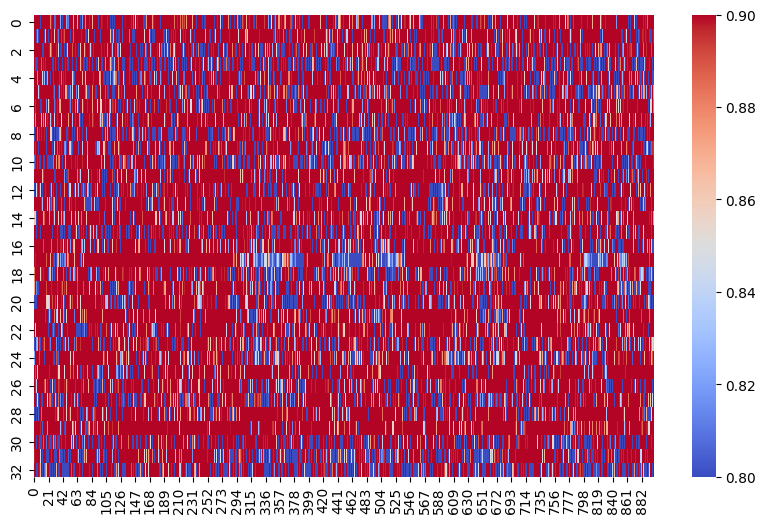

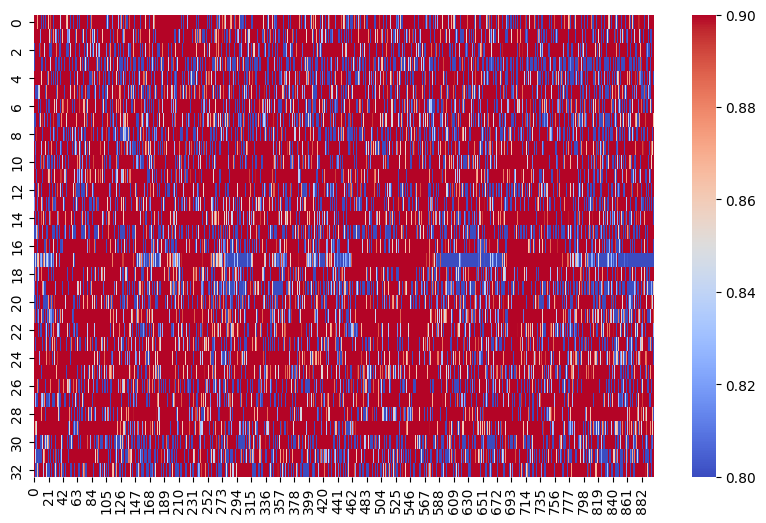

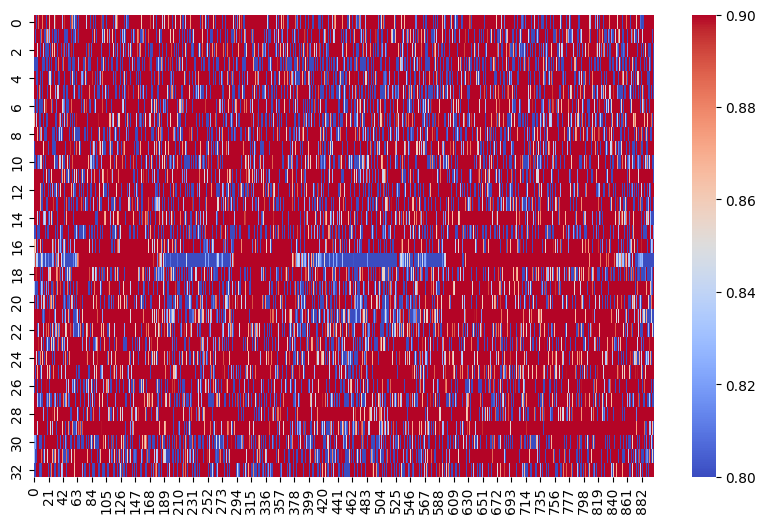

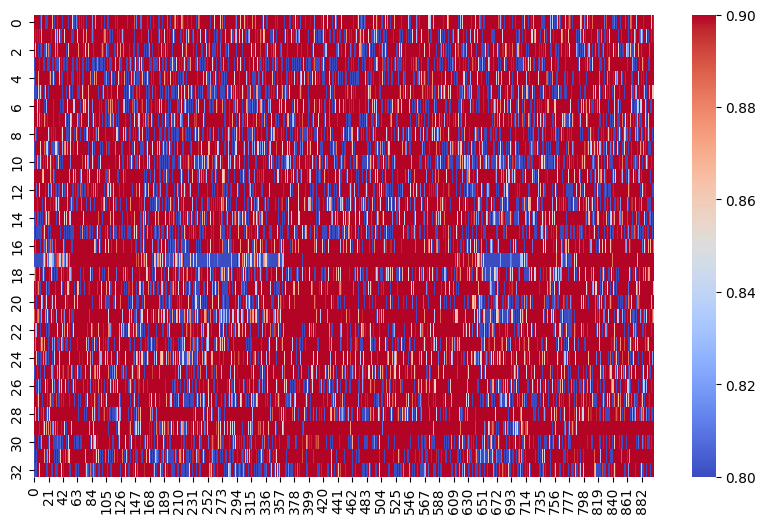

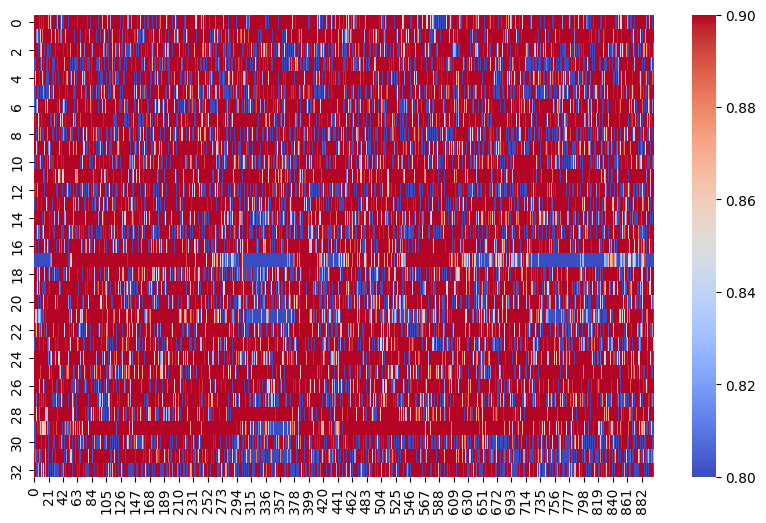

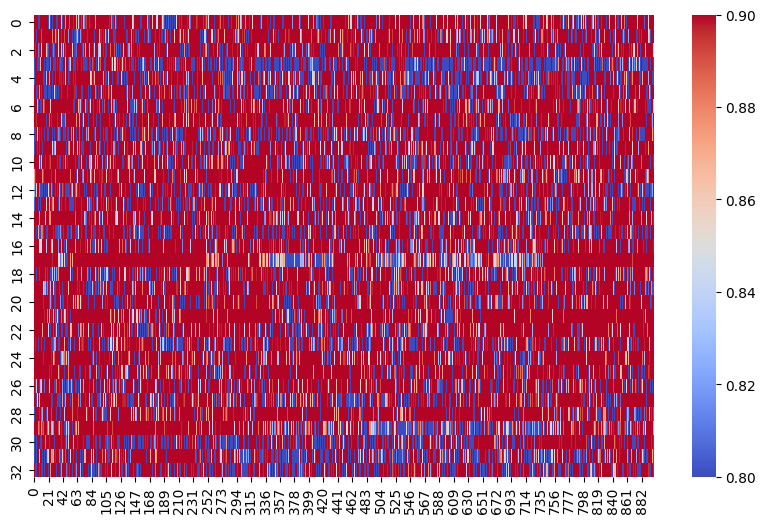

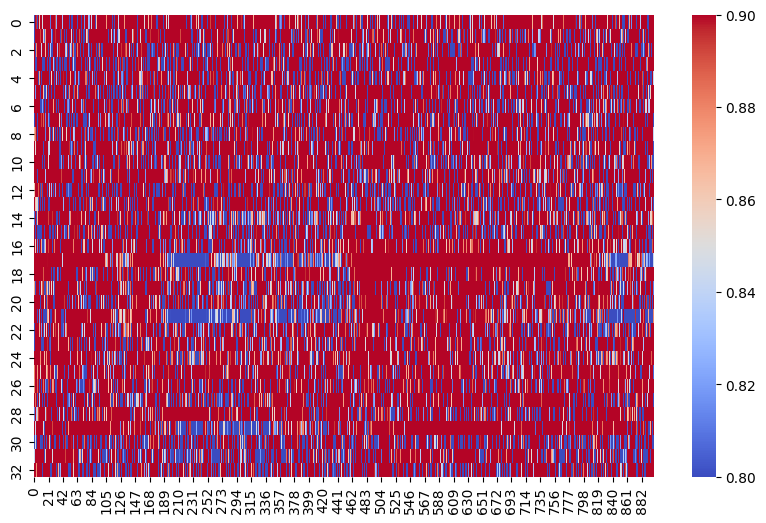

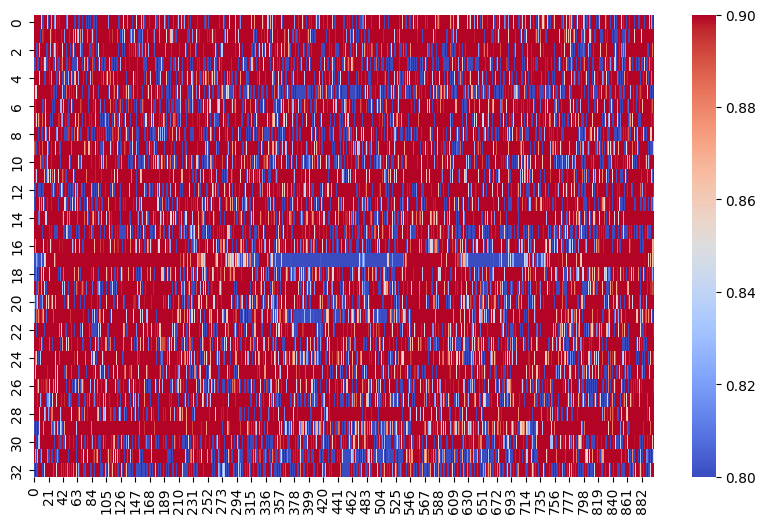

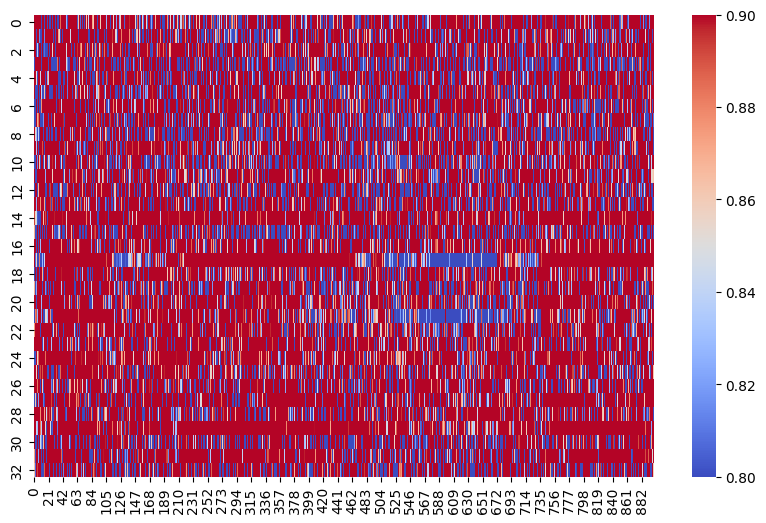

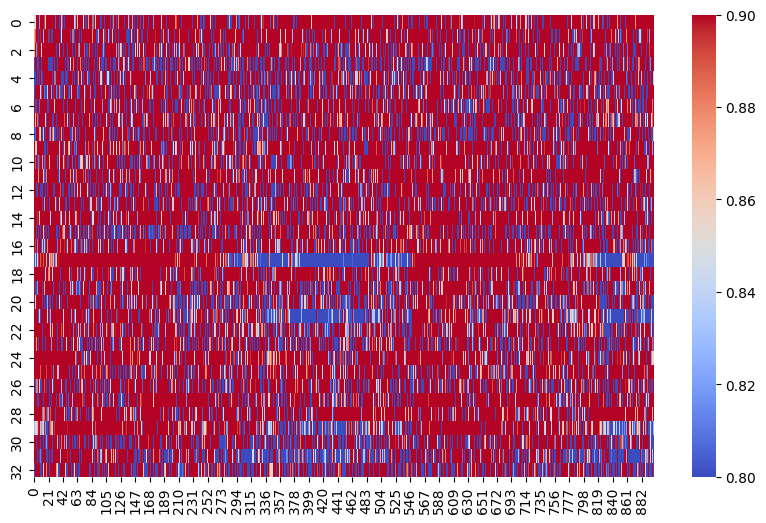

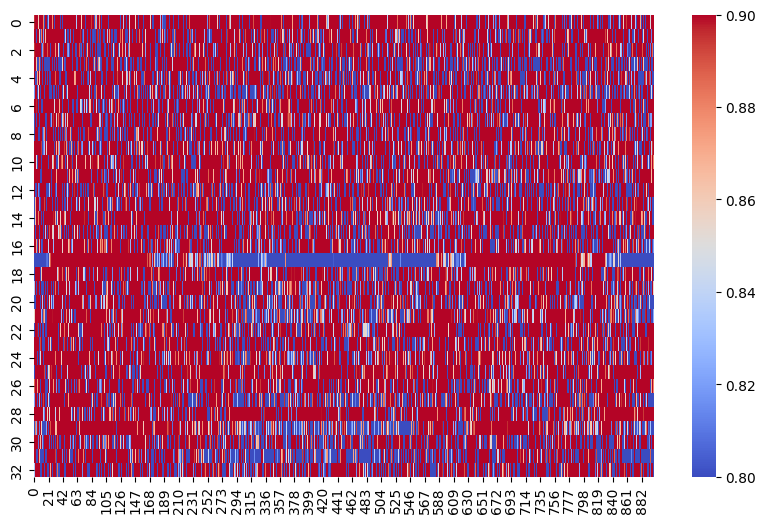

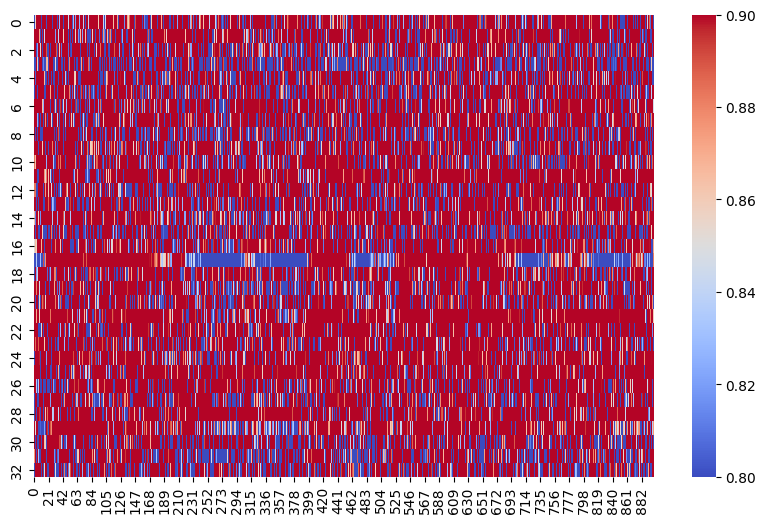

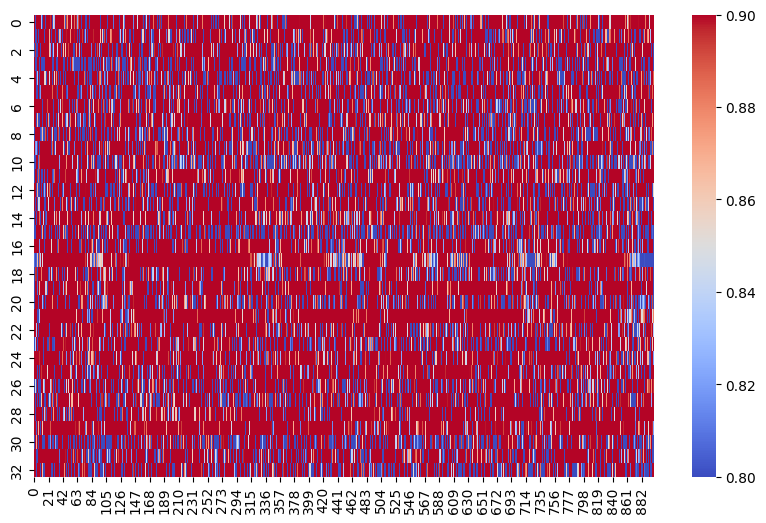

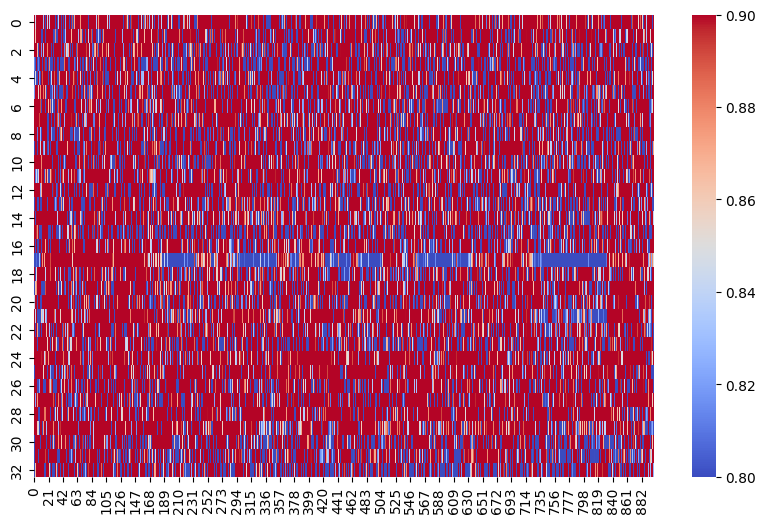

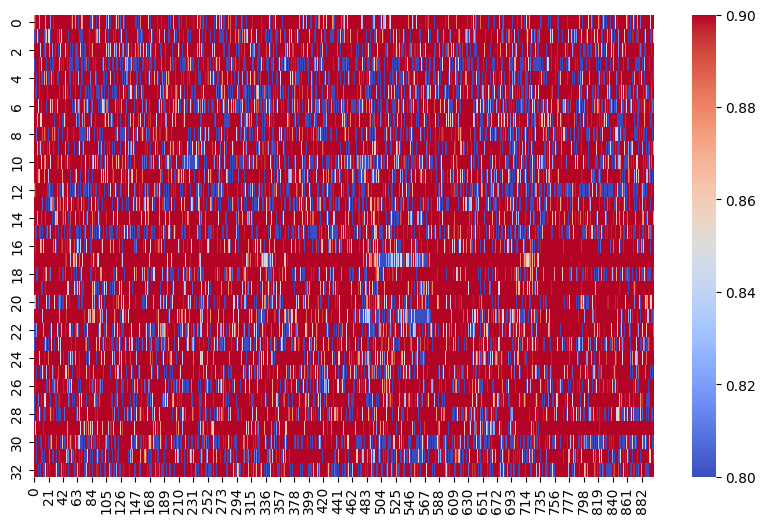

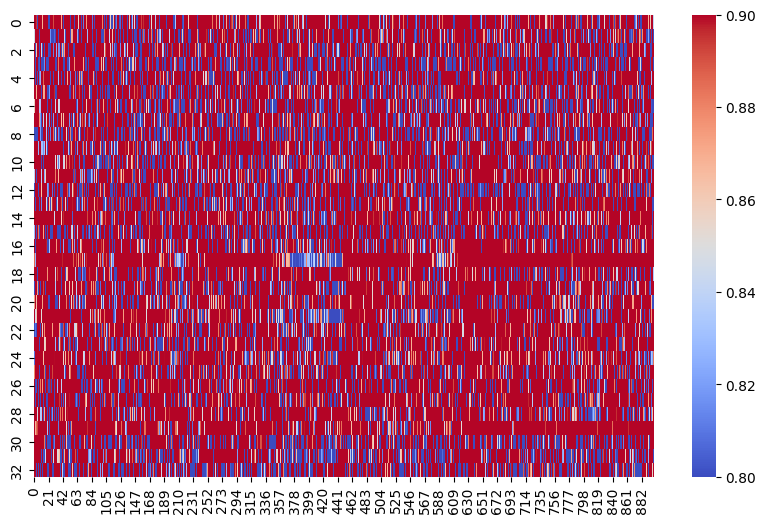

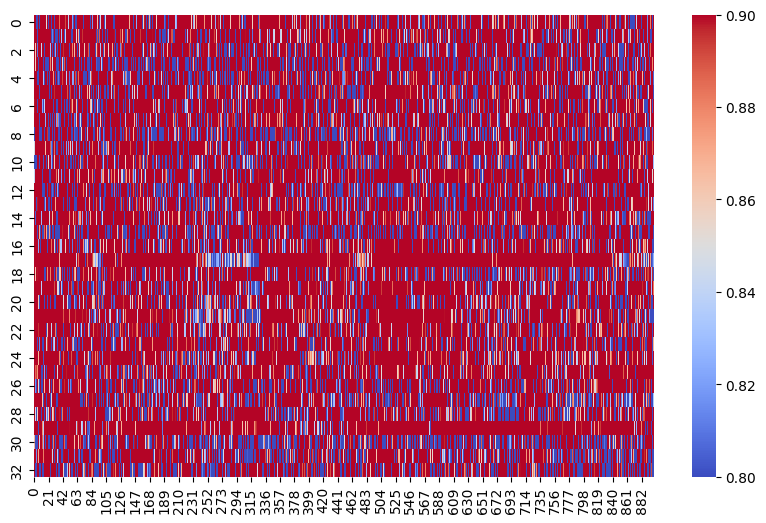

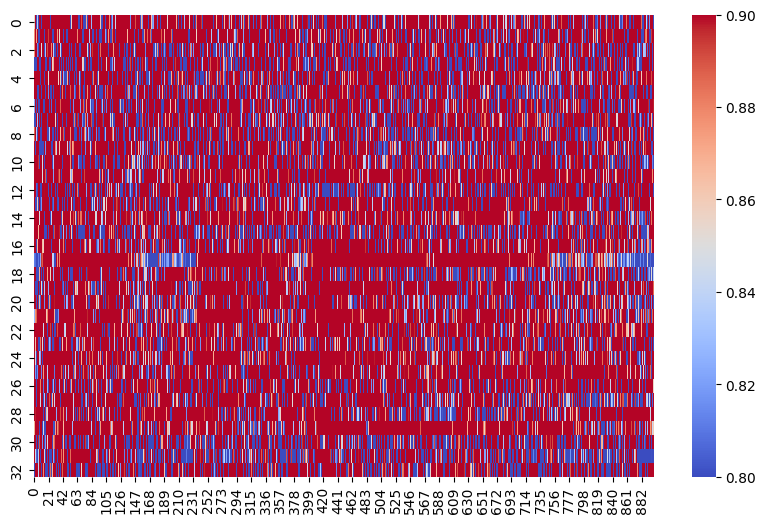

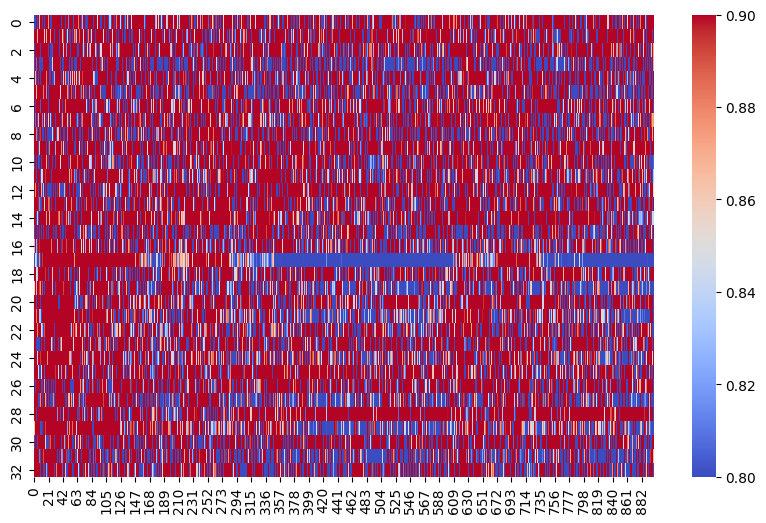

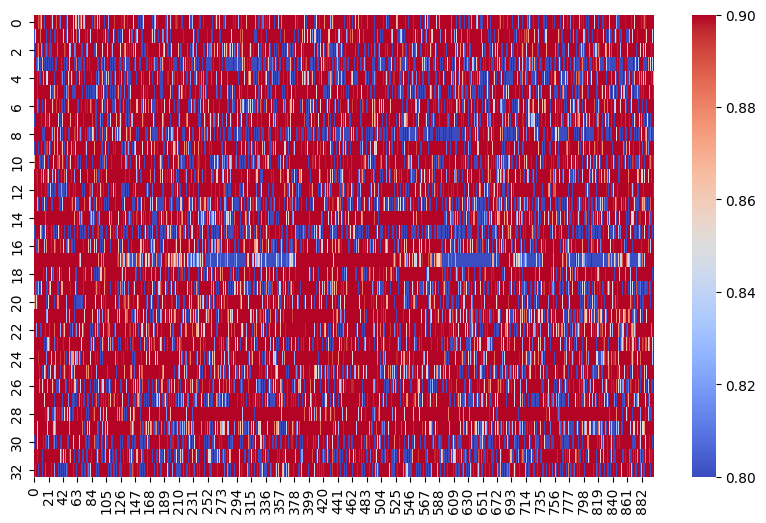

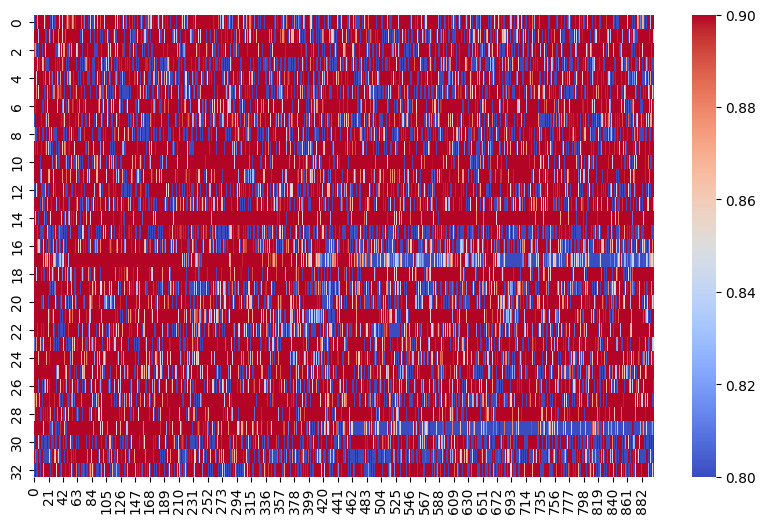

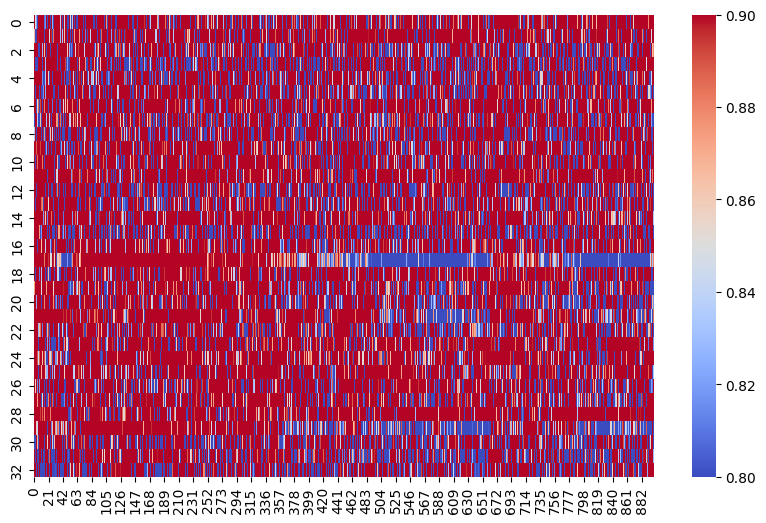

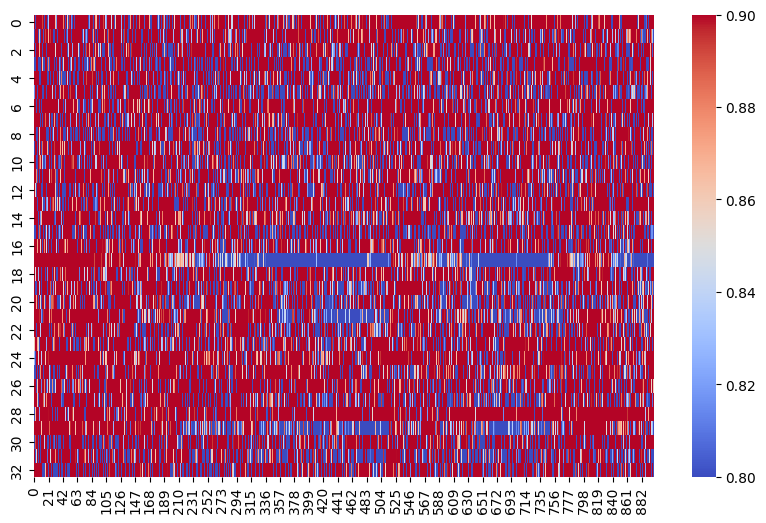

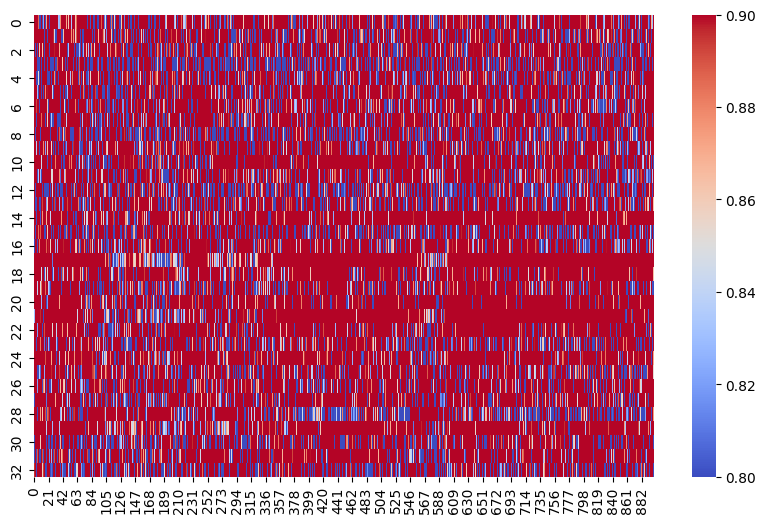

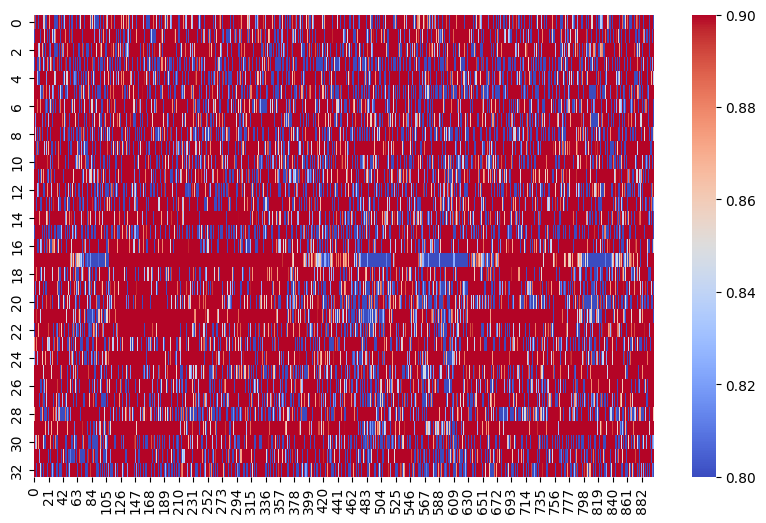

In [305]:
for bout in aligned_dff:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(bout, cmap='bwr', ax=ax, vmin = 0.8, vmax = 0.9)

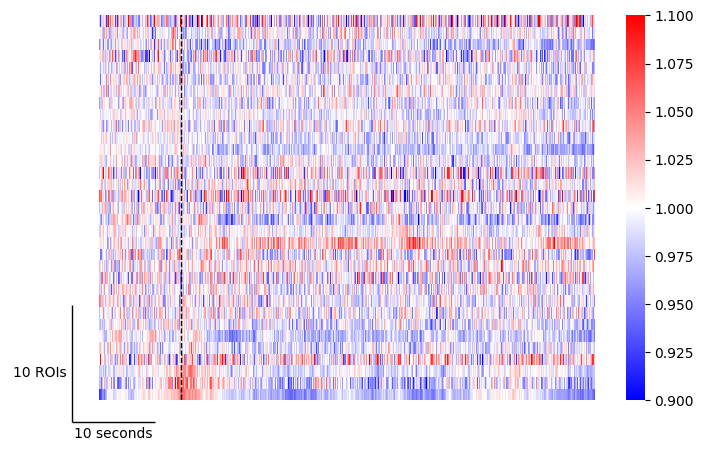

In [302]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ascending_order = np.argsort(np.nanmean(avg_dff[:, 150:180], axis=1))
sorted_avg_mean = avg_dff[ascending_order, :]
for cell in range(sorted_avg_mean.shape[0]):
    sorted_avg_mean[cell, :] = p2p.moving_average(sorted_avg_mean[cell, :], 2)
sns.heatmap(sorted_avg_mean, ax = ax, vmin=0.9, vmax=1.1, cmap='bwr')
ax.vlines(x = 150, ymin = -1, ymax = avg_dff.shape[0] + 1, color = 'black', linestyle = '--', lw = 1)
# ax.set_xticks(np.arange(15, 255, 15)[::2])
# ax.set_xticklabels((np.arange(15, 255, 15)/15).astype(int)[::2]-5)
ax.set_ylabel("ROI (Trial-Averaged)")
ax.set_xlabel("Time from First Lick")
# ax.set_xlim(left = 45, right = 180)
sb = add_scalebar(ax, matchx=False, sizex=10*15, labelx='10 seconds', matchy=False, sep=4, sizey=-10, labely='10 ROIs',loc='lower left', bbox_to_anchor=(10, 10, 0.1, 0.4))


(-89.0967, 600.0)

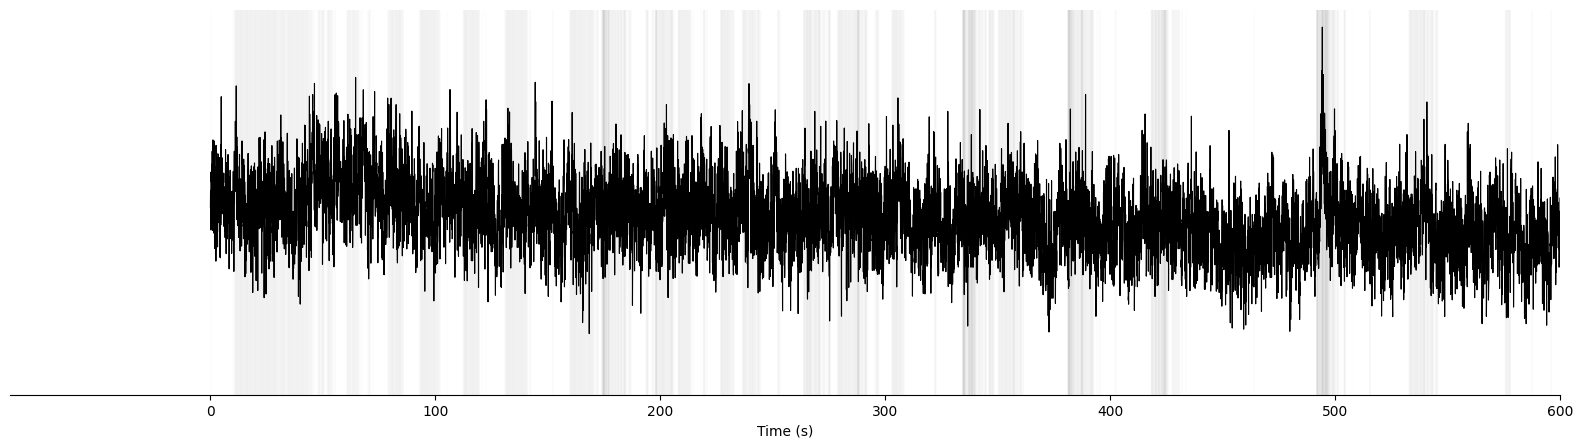

In [269]:
c = 0
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
# for cell in range(filt_f_norm.shape[0]):
# for cell in [2, 23, 25, 28, 32]:
# Average across cells
ax.plot(time, np.mean(filt_f_norm, axis=0), color='black', lw=0.8, label='Average dF/F')
sns.despine(ax=ax, left = True, bottom = False)
for lick in licks:
    ax.axvline(lick, c = 'black', alpha=0.05, linewidth=0.2)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Time (s)')
ax.set_xlim(right = 600)


Text(0.5, 0, 'Time (s)')

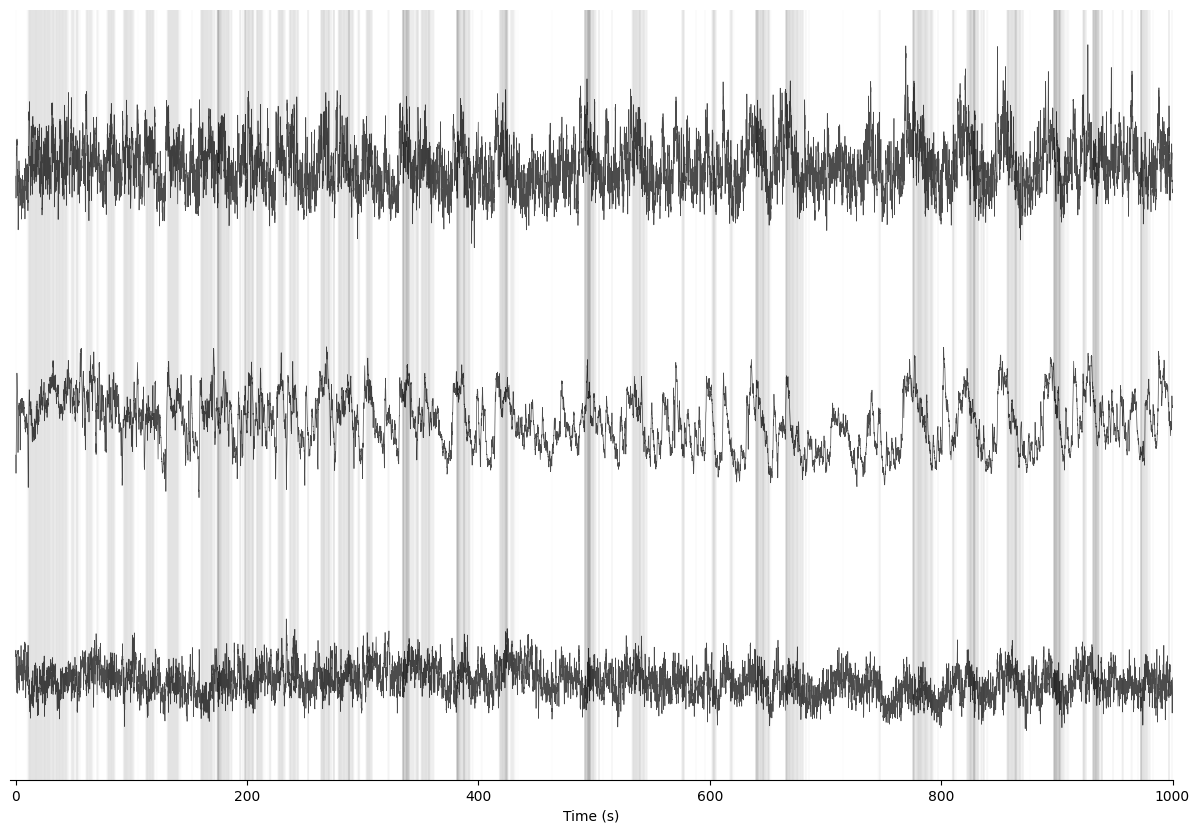

In [265]:

c = 0
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for cell in range(filt_f_norm.shape[0]):
# for cell in [2, 23, 25, 28, 32]:
for cell in [14, 17, 31]:
    ax.plot(time, p2p.moving_average(filt_f_norm[cell, :], 5) + 1.5 * c, alpha=0.7, linewidth = 0.5, c = 'black')
    c += 1
for lick in licks:
    ax.axvline(lick, c = 'black', alpha=0.05, linewidth=0.2)
ax.set_xlim(left = -5, right = 1000)
    # ax.set_title(f'Cell {cell}')

sns.despine(ax=ax, left = True, bottom = False)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Time (s)')



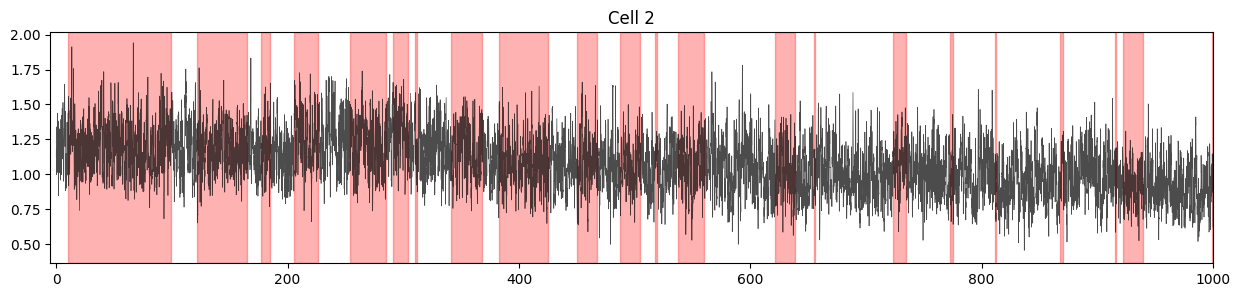

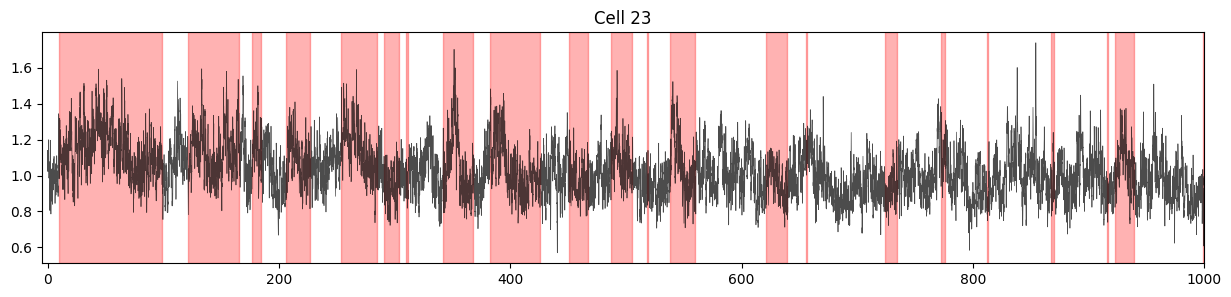

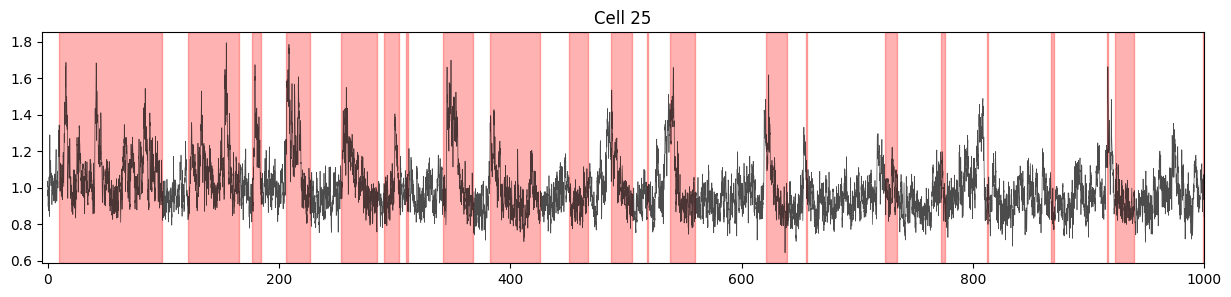

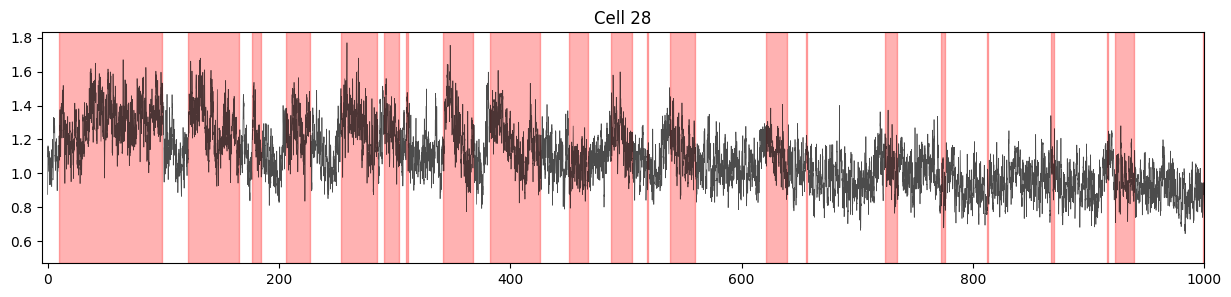

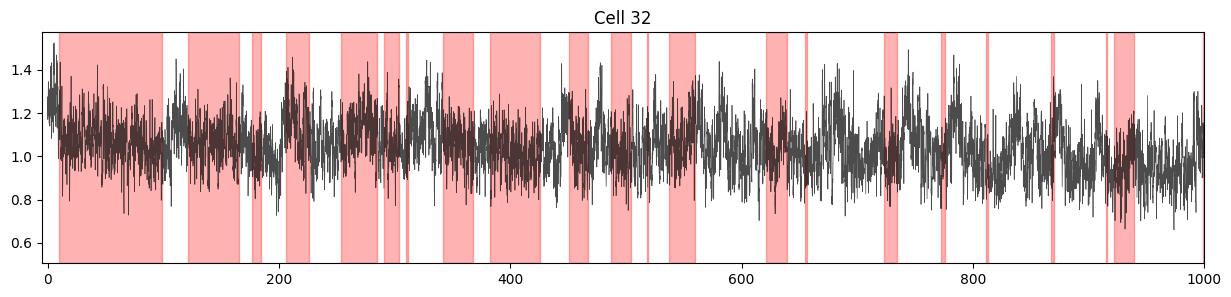

In [177]:

c = 0
# for cell in range(filt_f_norm.shape[0]):
for cell in [2, 23, 25, 28, 32]:
# for cell in [14, 17, 31]:
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(time, p2p.moving_average(filt_f_norm[cell, :], 5), alpha=0.7, linewidth = 0.5, c = 'black')
    for bout in range(len(bout_on)):
        ax.axvspan(bout_on[bout], bout_off[bout], color='red', alpha=0.3)
    ax.set_xlim(left = -5, right = 1000)
    ax.set_title(f'Cell {cell}')


Text(0.5, 0, 'Time (s)')

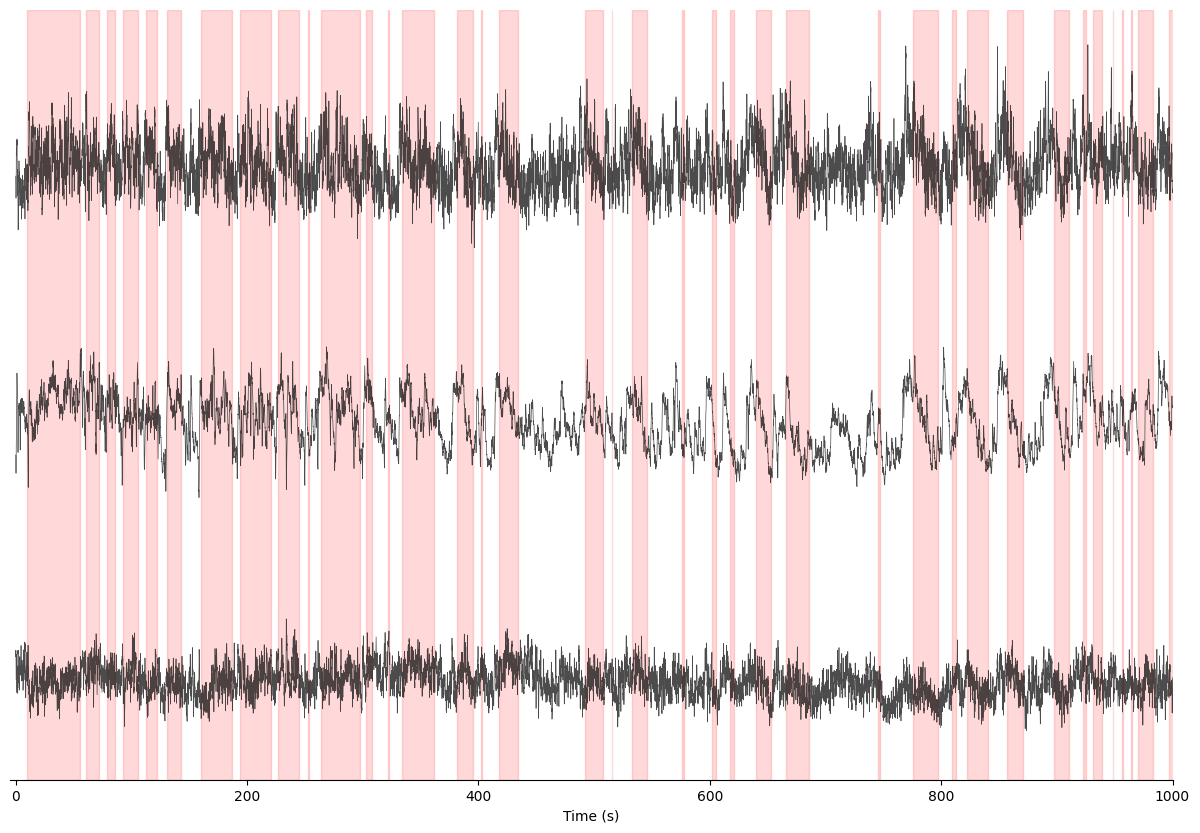

In [201]:
c = 0
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for cell in range(filt_f_norm.shape[0]):
# for cell in [2, 23, 25, 28, 32]:
for cell in [14, 17, 31]:
    ax.plot(time, p2p.moving_average(filt_f_norm[cell, :], 5) + 1.5 * c, alpha=0.7, linewidth = 0.5, c = 'black')
    for bout in range(len(bout_on)):
        ax.axvspan(bout_on[bout], bout_off[bout], color='red', alpha=0.05)
    ax.set_xlim(left = -5, right = 1000)
    # ax.set_title(f'Cell {cell}')
    c += 1
sns.despine(ax=ax, left = True, bottom = False)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Time (s)')
